# Spectral exponent of natural scenes
Here we will load images of Natural Scenes from the Allen Brain Observatory: Visual Coding dataset. We will then perform a 2-dimensional Fourier Transform of the images and compute the spectral exponent. Finally, we will select groups of images with contrasting spectral exponents as candidate stimuli.


## Set-up

### Set local path

In [1]:
# local path to Allen Visual Coding dataset. This is where the image data will be downloaded.
MANIFEST_PATH = "G:/Shared drives/visual_encoding/manifest.json" # SET THIS TO YOUR LOCAL PATH

### Package installation for running in Google Colab

In [2]:
! pip install allensdk
! pip install specparam

  Using cached specparam-2.0.0rc0-py3-none-any.whl (131 kB)


### Imports

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import rcParams
from scipy.fftpack import fft2, ifftshift
from scipy.signal import welch
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from specparam import SpectralModel

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Settings

In [4]:
# dataset details
N_SCENES = 118
DATASET_1 = np.arange(58)
DATASET_2 = np.arange(58,101)
DATASET_3 = np.arange(101,N_SCENES)

In [5]:
# plotting settings

# font sizes
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["legend.fontsize"] = 12


### Functions

In [6]:
# plotting functions

def show_image(image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()


def plot_results(image, ft, ft_freqs, sm):
    fig = plt.figure(figsize=(12, 4))
    spec = gs.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1.5, 1, 1])

    # plot image
    ax0 = plt.subplot(spec[0, 0])
    ax0.imshow(image, cmap='gray')
    ax0.set_title('Image')
    ax0.axis('off')

    # plot FT
    ax1 = plt.subplot(spec[0, 1])
    ax1.set_title('Fourier Transform')
    ax1.pcolormesh(ft_freqs[0], ft_freqs[1], np.log(np.abs(ft)**2).T, cmap='gray', shading='auto')
    ax1.set(xlabel='frequency (cycles/image)', ylabel='frequency (cycles/image)')

    # plot spectral model fit to 1d power spectrum
    ax2 = plt.subplot(spec[0, 2])
    sm.plot(ax=ax2, show=False, plt_log=True)
    ax2.set_title('Power Spectrum')
    ax2.legend().remove()
    ax2.grid(False)
    exponent = sm.get_params('aperiodic', 'exponent')
    ax2.text(0.1, 0.1, f'Exponent: {exponent:.2f}', horizontalalignment='left', 
            verticalalignment='center', transform=ax2.transAxes, fontsize=14,
            color='r')
    
    plt.show()


In [7]:
# analysis functions


def analyze_image(image, plot=False):
    """Compute the spectral exponent of an image.
    1. Preprocess the image by applying a Gaussian window.
    2. Compute the 2D Fourier transform of the windowed image.
    3. Compute the 1D power spectrum via azimuthal integration 
      of the 2D FFT.
    4. Compute the spectral exponent by fitting a 1/f^exponent 
      model to the 1D power spectrum.
    5. Optionally, plot the image, its FT, and its 1D power spectrum.

    Parameters
    ----------
    image : array_like
      The image to transform.
    plot : bool
      If True, plot the image, its FT, and its 1D power spectrum.

    Returns
    -------
    exponent : float
      The exponent of the 1D power spectrum of the image.
    r_squared : float
      The r-squared value of the spectral model fit.
    """

    # Preprocess the image
    image_p = window_image(image)

    # Compute the 2D Fourier transform of the image
    ft, ft_freqs = fft_2d(image_p)

    # Compute the 1D power spectrum from the 2D FT
    spectrum, freqs = ft_to_spectrum(ft, ft_freqs)

    # Parameterize the 1D power spectrum
    sm = SpectralModel(aperiodic_mode='fixed', verbose=False, max_n_peaks=0)
    sm._check_freqs=False
    sm.fit(freqs, spectrum)
    
    # Get spectral parameters
    exponent = sm.get_params('aperiodic_params', 'exponent')
    r_squared = sm.get_params('r_squared')

    # plot
    if plot:
      plot_results(image, ft, ft_freqs, sm)

    # return
    return exponent, r_squared


def window_image(image):
  """
  Apply Gaussian window to image.
  """
  
  # create gaussian window 
  width, height = image.shape
  gauss_window = gassian_2d(size=[height, width], center=[height//2, width//2], 
                            sigma=np.min(image.shape)//3)
  
  # apply window
  image = image * gauss_window

  return image


def gassian_2d(size=[918,1184], center=[459,587], sigma=1):
    """
    Make a square gaussian kernel.

    Parameters
    ----------
    size : int, array_like
        Size of the gaussian kernel
    center : float
        Center of the gaussian kernel
    sigma: float
        Standard deviation of the gaussian kernel

    Returns
    -------
    gaussian : ndarray
        2D gaussian kernel
    """

    x_arr = np.arange(0,size[0], 1, float)
    y_arr = np.arange(0,size[1], 1, float)[:,np.newaxis]

    gaussian = np.exp(-(((x_arr-center[0])**2)/(2*(sigma**2)) + \
                        ((y_arr-center[1])**2) /(2*(sigma**2))))

    return gaussian


def fft_2d(image):
    """Compute the 2D Fourier transform of an image.

    Parameters
    ----------
    image : array_like
      The image to transform.

    Returns
    -------
    ft : ndarray
      The 2D Fourier transform of the image.
      
    """

    # Compute the 2D Fourier transform.
    ft = fft2(image)

    # Shift the Fourier transform so that the origin is at the center.
    ft = ifftshift(ft)

    # define the frequency axes (in cycles/image)
    freqs_x = np.fft.fftshift(np.fft.fftfreq(image.shape[0])) * image.shape[0]
    freqs_y = np.fft.fftshift(np.fft.fftfreq(image.shape[1])) * image.shape[1]
    freqs = np.meshgrid(freqs_x, freqs_y)

    return ft, freqs


def ft_to_spectrum(ft, freqs):
  """
  Compute the 1D power spectral density (PSD) from a 2D Fourier transform.
  Performs azimuthal integration of the 2D FT.
  
  Parameters
  ----------
  ft : array_like
    The 2D Fourier transform of an image.

  Returns
  -------
  spectrum : ndarray
    1D power spectral density of the image.
  """
  
  # imports
  from scipy import ndimage

  # compute the radial distance from the center for each pixel
  radius_grid = np.hypot(freqs[0], freqs[1])
  radius = np.sort(np.unique(radius_grid))

  # compute power as squared magnitude of FT
  power = np.abs(ft)**2

  # azimuthal integration: sum power values at equal distance from the center (upper triangle only)
  spectrum = ndimage.sum(np.triu(power), radius_grid.T, index=radius)

  # only keep values that are equally represented in the FT (i.e. not in the corners)
  max = np.min([np.max(freqs[0]), np.max(freqs[1])])
  spectrum = spectrum[radius <= max]
  radius = radius[radius <= max]

  # resample spectrum to be equally spaced
  freqs = np.logspace(0, np.log10(max), num=128)
  spectrum = np.interp(freqs, radius, spectrum)

  return spectrum, freqs



## Demo analysis pipeline

### Load image
Load natural scene from the Allen Brain Observatory dataset

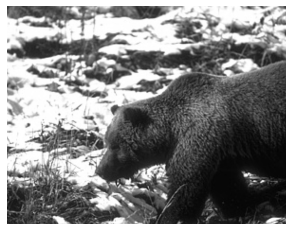

In [9]:
# load example image

# choose example image to display
scene_idx = 1

# load AllenSDK Brain Observatory project cache
cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

# load image and show
scene = cache.get_natural_scene_template(scene_idx)
show_image(scene)

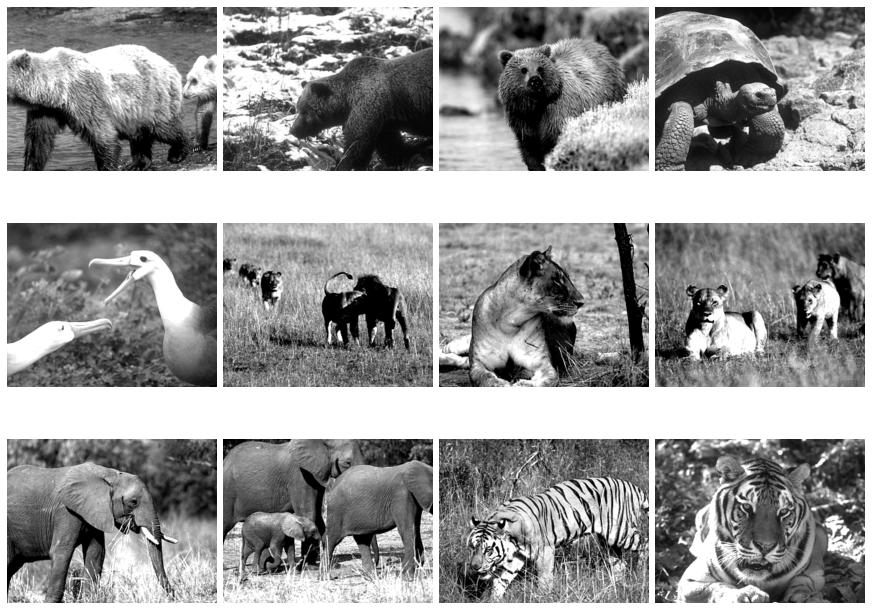

In [9]:
# load a few more images and display them

# load
n_scenes = 12
scenes = np.zeros((n_scenes, scene.shape[0], scene.shape[1]))
for scene_idx in range(n_scenes):
    scene = cache.get_natural_scene_template(scene_idx)
    scenes[scene_idx] = scene

# show
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs.GridSpec(3, 4)
for scene_idx in range(n_scenes):
    plt.subplot(3, 4, scene_idx + 1)
    plt.imshow(scenes[scene_idx], cmap='gray')
    plt.axis('off')

### Pre-process image
Apply Gaussian window to image (this will reduce edge-effects when computing the FFT)

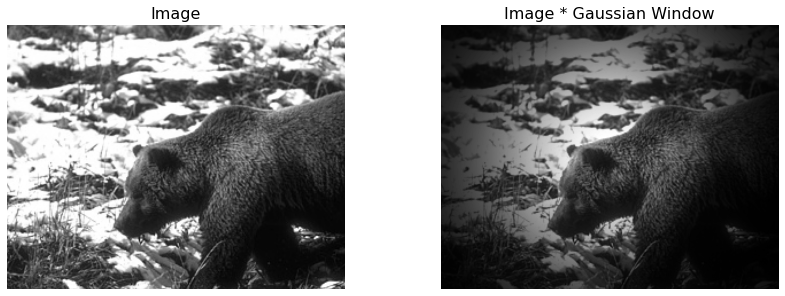

In [10]:
# Preprocess image

# load image
scene_idx = 1
image = cache.get_natural_scene_template(scene_idx)

# preprocess - apply gaussian window
image_w = window_image(image)

# plot each
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12, 4), constrained_layout=True)
ax0.imshow(image, cmap='gray')
ax0.set_title('Image')
ax0.axis('off')
ax1.imshow(image_w, cmap='gray')
ax1.set_title('Image * Gaussian Window')
ax1.axis('off')
plt.show()

### Compute FFT
Compute 2D Fourier transform of pre-processed image, then compute the power spectrum via azimuthal integration

In [11]:
# compute FT of example image

# load image and preprocess
scene_idx = 1
image = cache.get_natural_scene_template(scene_idx)
image_w = window_image(image)

# compute FFT
ft, ft_freqs = fft_2d(image_w)

# compute 1d power spectrum from 2d FT
spectrum, freqs = ft_to_spectrum(ft, ft_freqs)


Text(0, 0.5, 'Power')

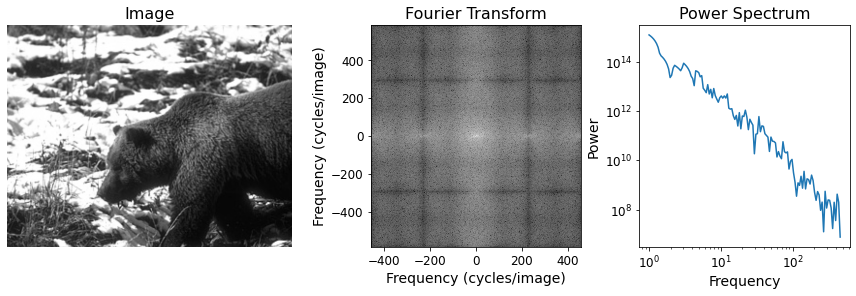

In [12]:
# plot results

# create figure
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
spec = gs.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1.5, 1, 1])

# plot image
ax0 = fig.add_subplot(spec[0])
ax0.imshow(image, cmap='gray')
ax0.set_title('Image')
ax0.axis('off')

# plot FT
ax1 = fig.add_subplot(spec[1])
ax1.pcolormesh(ft_freqs[0], ft_freqs[1], np.log(np.abs(ft)**2).T, cmap='gray', shading='auto')
ax1.set_title('Fourier Transform')
ax1.set_xlabel('Frequency (cycles/image)')
ax1.set_ylabel('Frequency (cycles/image)')

# plot 1d power spectrum
ax2 = fig.add_subplot(spec[2])
ax2.loglog(freqs, spectrum)
ax2.set_title('Power Spectrum')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')

### Compute spectral exponent
Fit a 1/f^exponent model to the image power spectrum

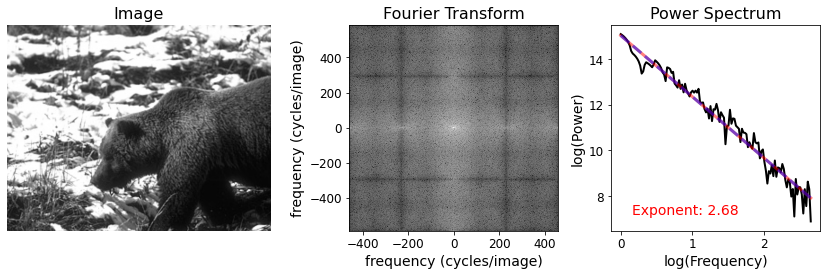

Exponent: 2.68
R-squared: 0.97


In [13]:
# analyze example image and show results
exponent, r_squared = analyze_image(image, plot=True)

print(f'Exponent: {exponent:.2f}')
print(f'R-squared: {r_squared:.2f}')


## Analyze all natural scene stimuli in Brain Observatory dataset

In [10]:
# Run analysis on all images in dataset

# init
exponent = np.zeros(N_SCENES)
r_squared = np.zeros(N_SCENES)
n_images = N_SCENES

# analyze each image
for idx in range(N_SCENES):
    scene = cache.get_natural_scene_template(idx)
    exponent[idx], r_squared[idx] = analyze_image(scene)

# print results
print(f'Mean spectral exponent: {np.mean(exponent):.2f}')
print(f'Median r-squared value: {np.median(r_squared):.2f}')

Mean spectral exponent: 2.61
Median r-squared value: 0.96


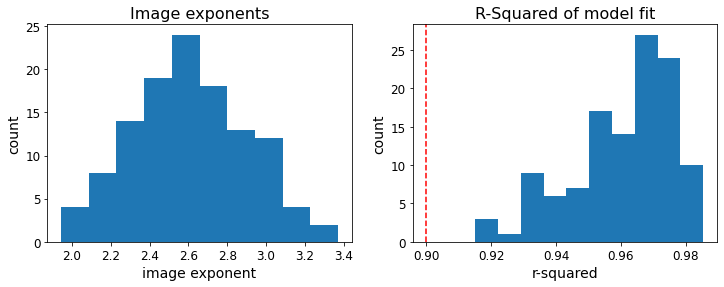

In [15]:
# plot histogram of exponents and r-squared values

# create figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])

# plot image exponents
ax1.hist(exponent)
ax1.set(xlabel="image exponent", ylabel="count")
ax1.set_title("Image exponents")

# plot r-squared of spectral model 
ax2.hist(r_squared)
ax2.set(xlabel="r-squared", ylabel="count")
ax2.set_title("R-Squared of model fit")
ax2.axvline(0.9, color='r', linestyle='--')

plt.show()

## Choose candidate images

### show images with extreme exponent values

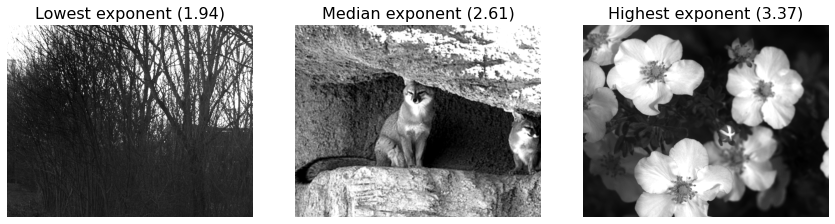

In [16]:
# show images with extreme values

# get indices of images with extreme exponents
idx_median = np.argmin(np.abs(exponent - np.median(exponent)))
indices = np.array([np.argmin(exponent), idx_median, np.argmax(exponent)])

# show images
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs.GridSpec(1, 3)
for i, (scene_idx, title) in enumerate(zip(indices, ['Lowest', 'Median', 'Highest'])):
    scene = cache.get_natural_scene_template(scene_idx)
    plt.subplot(1, 3, i + 1)
    plt.imshow(scene, cmap='gray')
    plt.axis('off')
    plt.title(f"{title} exponent ({exponent[scene_idx]:.2f})")


High exponent images:


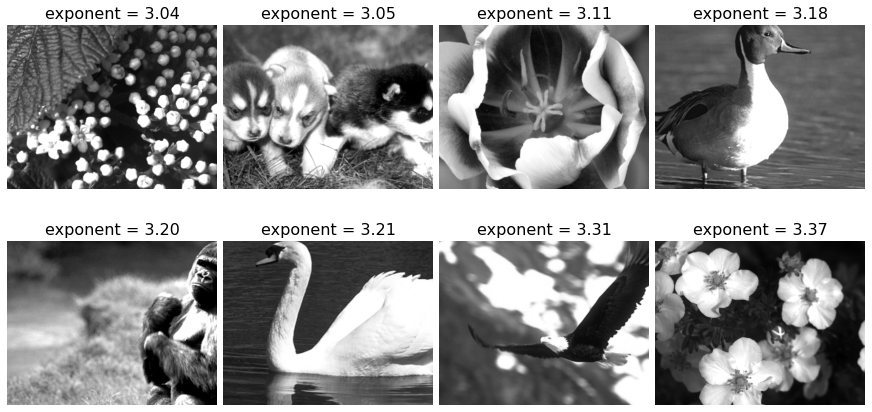

Low exponent images:


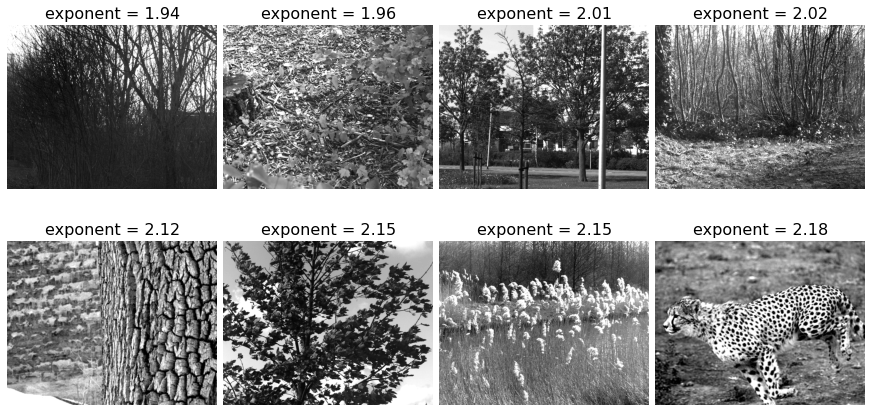

In [17]:
# plot 8 images with lowest/highest exponents
n_images = 8
idx_high = np.argsort(exponent)[-n_images:]
idx_low = np.argsort(exponent)[:n_images]

# plot high exponent images
print("High exponent images:")
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs.GridSpec(2, n_images//2)
for i, scene_idx in enumerate(idx_high):
    scene = cache.get_natural_scene_template(scene_idx)
    plt.subplot(2, n_images//2, i + 1)
    plt.imshow(scene, cmap='gray')
    plt.axis('off')
    plt.title(f"exponent = {exponent[scene_idx]:.2f}")
plt.show()

# plot low exponent images
print("Low exponent images:")
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs.GridSpec(2, n_images//2)
for i, scene_idx in enumerate(idx_low):
    scene = cache.get_natural_scene_template(scene_idx)
    plt.subplot(2, n_images//2, i + 1)
    plt.imshow(scene, cmap='gray')
    plt.axis('off')
    plt.title(f"exponent = {exponent[scene_idx]:.2f}")


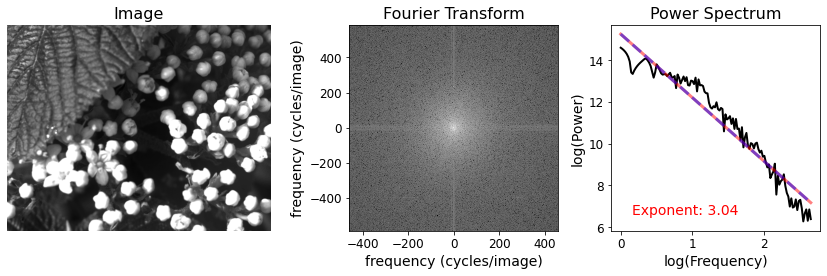

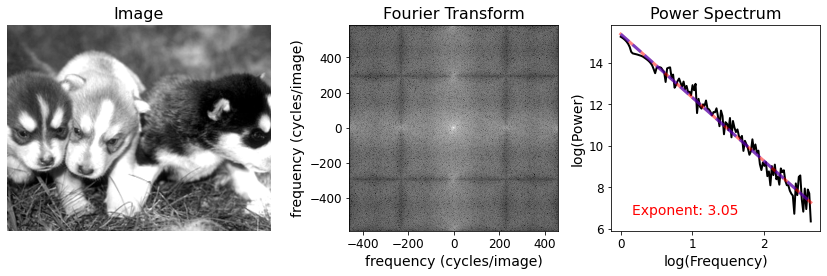

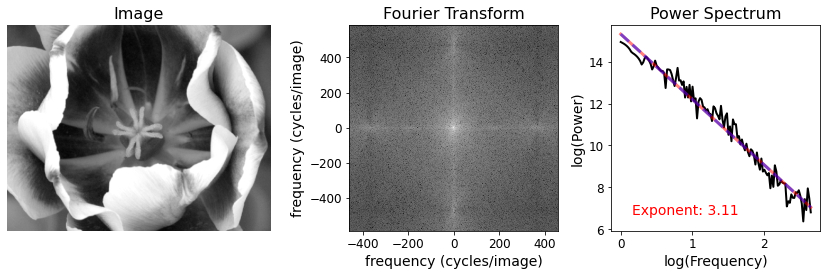

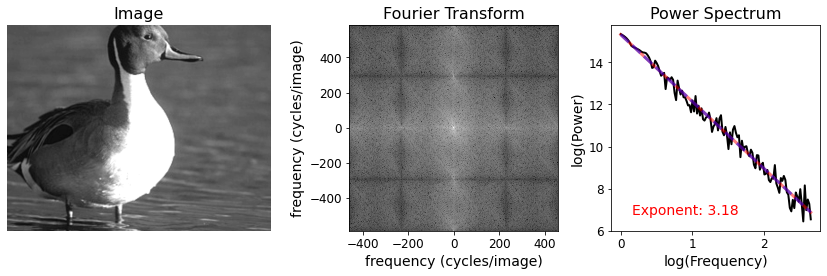

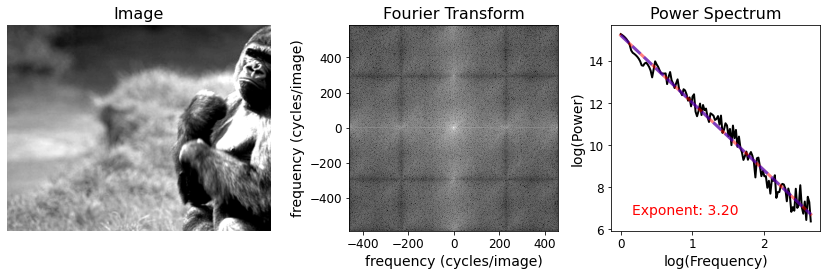

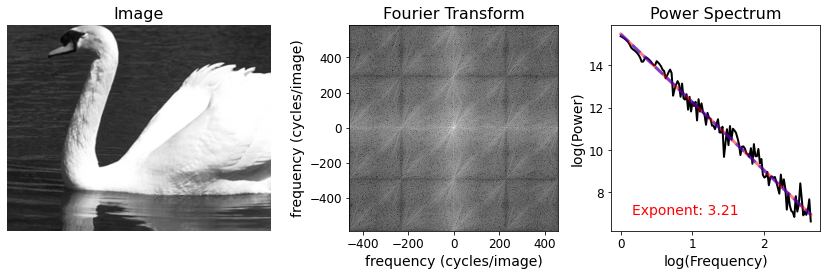

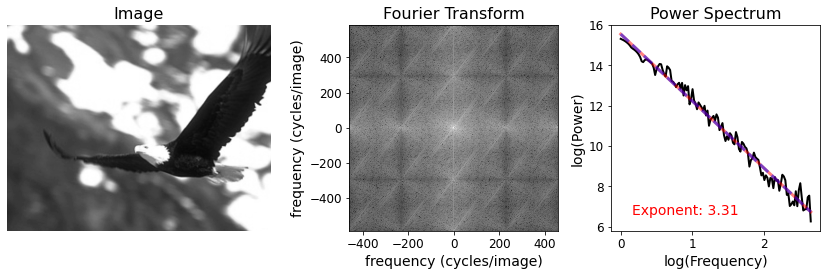

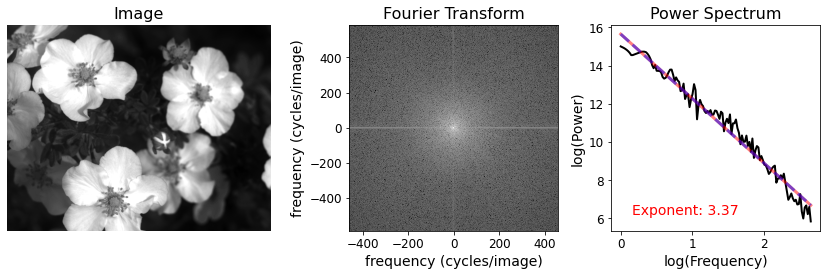

In [18]:
# plot analysis results for 10 images with highest exponent values
for index in idx_high:
    scene = cache.get_natural_scene_template(index)
    analyze_image(scene, plot=True);

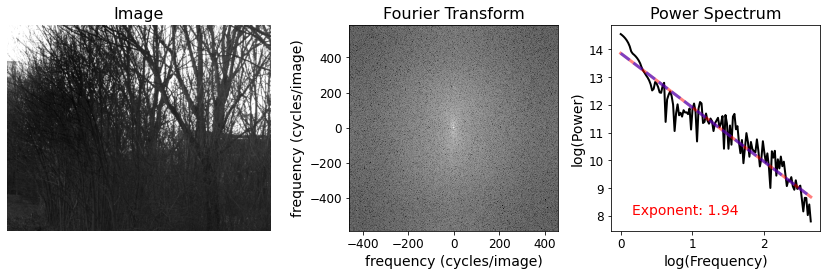

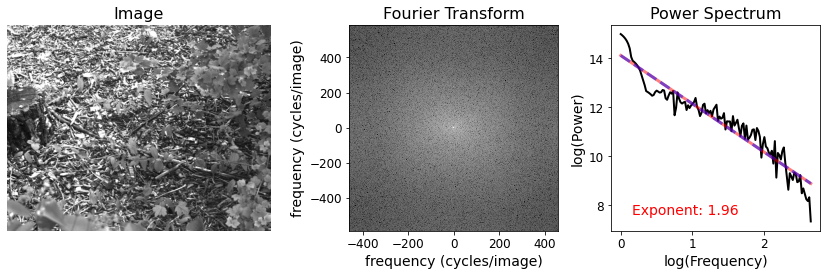

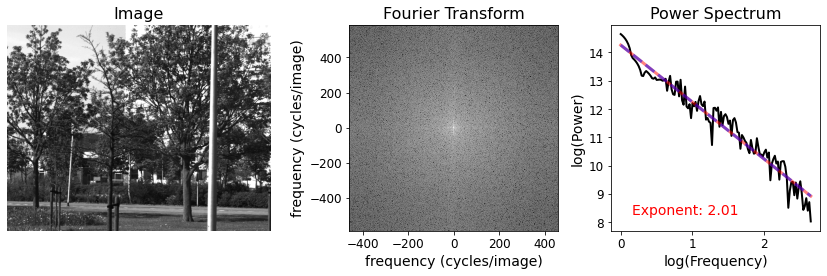

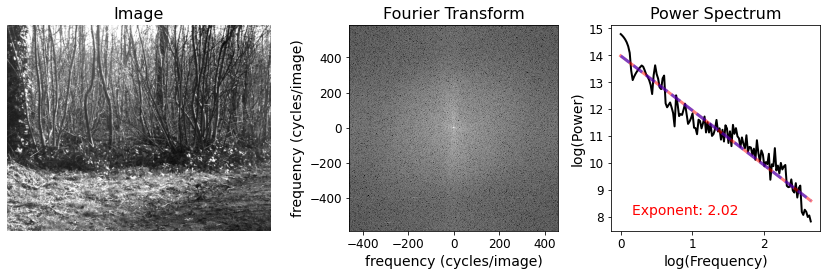

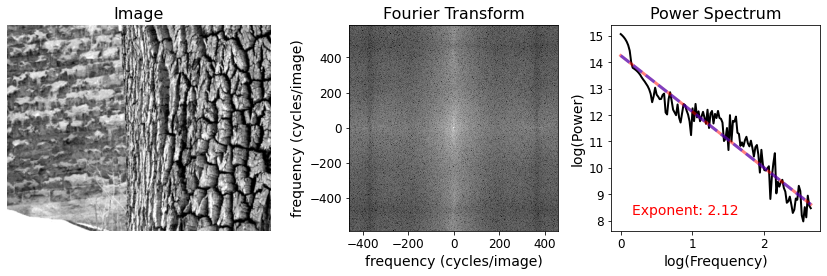

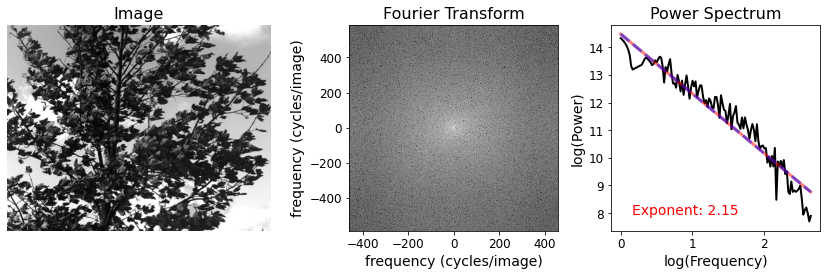

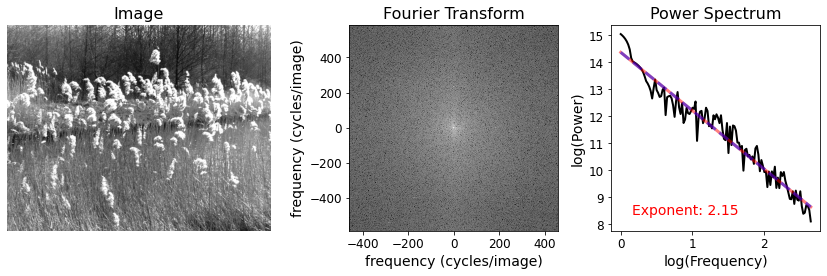

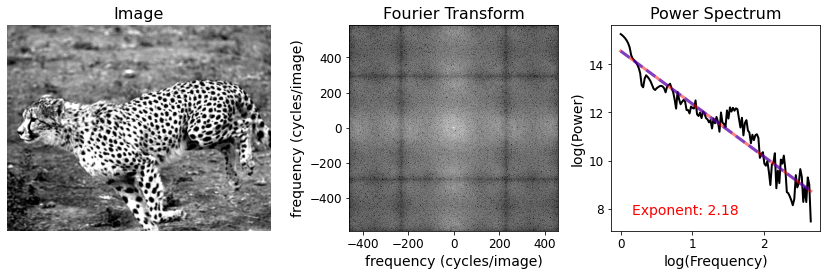

In [19]:
# plot analysis results for 10 images with lowest exponent values
for index in idx_low:
    scene = cache.get_natural_scene_template(index)
    analyze_image(scene, plot=True)

### save/show results
NOTE: The output paths in this section must be updated for your local system

In [20]:
# define variables
indices = np.arange(N_SCENES)
order = np.argsort(exponent)

# save
np.savez("G:/Shared drives/visual_encoding/data/results/image_exponents.npz", indices=indices, exponent=exponent, order=order)

In [28]:
# print/save indices of images with lowest/highest exponents
import pandas as pd

# create df of indices
n_stimuli = 30
order = np.argsort(exponent) 
idx_low = order[:n_stimuli] # lowest exponents are first
idx_high = order[-n_stimuli:][::-1] # reverse order so highest exponents are first 
df = pd.DataFrame({'low': idx_low, 'high': idx_high})

# save results to file
df.to_csv("G:/Shared drives/visual_encoding/data/results/image_indices.csv", index=False)

# show results
print(f"Lowest exponents:\t {idx_low}")
print(f"Highest exponents:\t {idx_high}")

Lowest exponents:	 [ 59  88  82  62 107  95  63  15  96 100 117  77 103 108  38  97  39  79
  98 116  91  84  10  76  25  72  22  92  51  80]
Highest exponents:	 [ 65  18  57  53  52 115  33  73  23 114   4  93  54  35  94  40 113  44
  69 111  60  50  66  29  42  86  71  55  30  85]
